# Data Description

In this competition, you will be analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species. 

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

# Main dataset

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

# Spray Data

The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

# Let's begin

download complete data from: https://www.kaggle.com/c/predict-west-nile-virus/data

Input data

In [1]:
"""
West Nile Virus Prediction @ Kaggle
"""
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble, preprocessing, linear_model, cluster, decomposition
import matplotlib.pyplot as plt
%matplotlib inline




# Load dataset 
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample = pd.read_csv('input/sampleSubmission.csv')
weather = pd.read_csv('input/weather.csv')
spray = pd.read_csv('input/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Not using codesum for this benchmark
weather = weather.drop('CodeSum', axis=1)

# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)
test['month'] = test.Date.apply(create_month)
test['day'] = test.Date.apply(create_day)

# Add integer latitude/longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)



# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test = test.drop(['Date'], axis = 1)



# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

# drop columns with -1s
train = train.ix[:,(train != -1).any(axis=0)]
test = test.ix[:,(test != -1).any(axis=0)]

#logistice regression model 
logreg = linear_model.LogisticRegressionCV(Cs=4, fit_intercept=True, cv=None, dual=False, 
                                           penalty='l2', scoring=None, solver='lbfgs', tol=0.00001, 
                                           max_iter=5000, class_weight='balanced', n_jobs=1, verbose=1, refit=True, 
                                           intercept_scaling=1.0, multi_class='multinomial', random_state=None)

#fit 
logreg.fit(train, labels)
print('Coeff: \n',logreg.coef_)

test_label = logreg.predict(test)
#print(logreg.predict(test))
print(logreg.scores_)
# create predictions and submission file
predictions = logreg.predict_proba(test)[:,1]
print(predictions)
sample['WnvPresent'] = predictions
sample.to_csv('logreg_result.csv', index=False)




/usr/lib/python2.7/dist-packages/pandas/core/common.py:361: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:701: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


('Coeff: \n', array([[-0.02599724,  0.00369297,  0.0001722 ,  0.00064028, -0.0021359 ,
         0.01147132,  0.05029044,  0.02563657,  0.00905461, -0.01112144,
        -0.00930174,  0.01776042,  0.01162434,  0.02211997,  0.02317787,
        -0.08966829,  0.02333204,  0.02038355, -0.0231323 ,  0.01331485,
         0.00944572, -0.00399645,  0.        ,  0.00115476, -0.00604727,
        -0.00514214, -0.00684098, -0.00843997,  0.01442147, -0.00822897,
        -0.00474924,  0.01486053,  0.00020882, -0.01717557, -0.00482436,
        -0.01070523,  0.00277287, -0.00102371, -0.00655315, -0.00662522,
        -0.00094081, -0.01631366, -0.00184653]]))


ValueError: X has 42 features per sample; expecting 43

In [102]:
# Random Forest Classifier 
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=1)
clf.fit(train, labels)

# create predictions and submission file
predictions = clf.predict_proba(test)[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)

In [ ]:
train = train.drop(['Block', 'Street','Latitude', 'Longitude',
       'month', 'day', 'Lat_int', 'Long_int', 'Depth_x', 'SnowFall_x',
        'StnPressure_x', 'SeaLevel_x', 'ResultSpeed_x',
       'ResultDir_x', 'AvgSpeed_x'], axis = 1)
test = test.drop(['Block', 'Street','Latitude', 'Longitude',
       'month', 'day', 'Lat_int', 'Long_int', 'Depth_x', 'SnowFall_x',
        'StnPressure_x', 'SeaLevel_x', 'ResultSpeed_x',
       'ResultDir_x', 'AvgSpeed_x'], axis = 1)

In [87]:
pca.fit(train)

PCA(copy=True, n_components=None, whiten=False)

ValueError: Invalid parameter logreg for estimator Pipeline(steps=[('pca', PCA(copy=True, n_components=20, whiten=False)), ('logistic', LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))]). Check the list of available parameters with `estimator.get_params().keys()`.

('Coeff: \n', array([[-0.01682338,  0.00167788,  0.00036507,  0.00192109, -0.00453038,
         0.01030176,  0.00675233,  0.00124274, -0.00459846, -0.00507778,
         0.01184859,  0.00217262,  0.01549405,  0.01048287, -0.04490769,
         0.01992979,  0.0189286 , -0.01325179,  0.00608347,  0.00789291,
        -0.00515429,  0.        ,  0.0004747 , -0.00357555, -0.00163557,
        -0.00398634, -0.01295804,  0.00749708, -0.00928107, -0.00729937,
         0.01600422,  0.00399031,  0.00526212,  0.00618016, -0.00897259,
         0.00387011,  0.0021586 , -0.00380171, -0.00391559, -0.00760616,
        -0.01177987, -0.00628105]]))
[ 0.01347547  0.01325364  0.01370096 ...,  0.10010933  0.0971187   0.1079462 ]


In [73]:
ridge_model = linear_model.Ridge (alpha=1.0, fit_intercept=True, 
                          normalize=True, copy_X=True, max_iter=1000, 
                          tol=0.001, solver='auto', random_state=None)
ridge_model.fit(train, labels)

# create predictions and submission file
predictions = ridge_model.predict(test)
print(predictions)
sample['WnvPresent'] = predictions
sample.to_csv('ridge_result1.csv', index=False)


[ 0.03169286  0.02083968  0.04254603 ...,  0.04878203  0.02707567
  0.10304791]


Describe data

In [57]:
train.describe(include='all')

TypeError: describe() got an unexpected keyword argument 'include'

In [60]:
train.columns

Index([u'Species', u'Block', u'Street', u'Trap', u'Latitude', u'Longitude', u'AddressAccuracy', u'month', u'day', u'Lat_int', u'Long_int', u'Tmax_x', u'Tmin_x', u'Tavg_x', u'Depart_x', u'DewPoint_x', u'WetBulb_x', u'Heat_x', u'Cool_x', u'Sunrise_x', u'Sunset_x', u'Depth_x', u'SnowFall_x', u'PrecipTotal_x', u'StnPressure_x', u'SeaLevel_x', u'ResultSpeed_x', u'ResultDir_x', u'AvgSpeed_x', u'Tmax_y', u'Tmin_y', u'Tavg_y', u'DewPoint_y', u'WetBulb_y', u'Heat_y', u'Cool_y', u'PrecipTotal_y', u'StnPressure_y', u'SeaLevel_y', u'ResultSpeed_y', u'ResultDir_y', u'AvgSpeed_y'], dtype='object')

In [7]:
len(train.columns)

42

## Make heatmap

script taken from: https://www.kaggle.com/c/predict-west-nile-virus/forums/t/13948/scripts-west-nile-virus-and-mosquito-heatmap-by-hear 

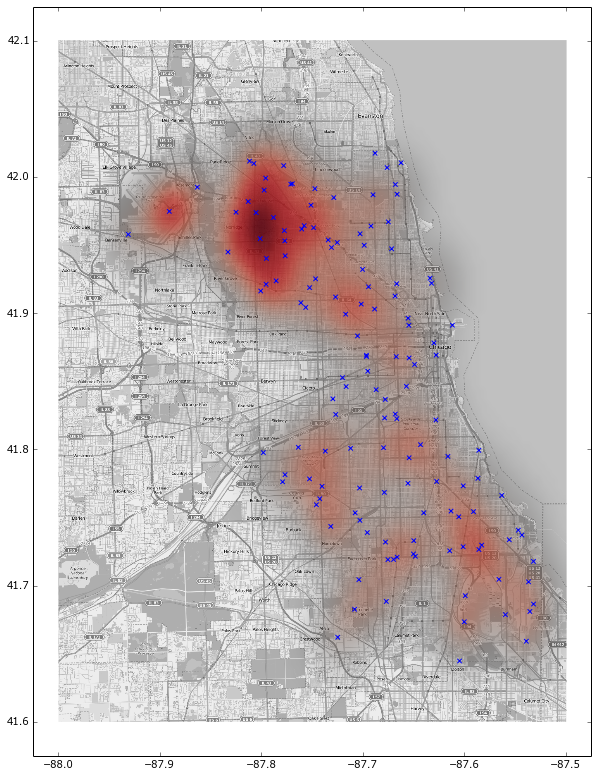

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KernelDensity,linear_model

mapdata = np.loadtxt("input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

sigthings = traps[traps['WnvPresent'] > 0]
sigthings = sigthings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
X = sigthings[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.02)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.imshow(zv, 
           origin='lower', 
           cmap=alpha_cm, 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.show()
#plt.savefig('heatmap.png')

Then this is a sample algorithm that implements random forest; from https://www.kaggle.com/abhishek/predict-west-nile-virus/vote-me-up

In [ ]:

# Get labels
labels = train.WnvPresent.values
print weather
# Not using codesum for this benchmark
weather = weather.drop('CodeSum', axis=1)

# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)
test['month'] = test.Date.apply(create_month)
test['day'] = test.Date.apply(create_day)

# Add integer latitude/longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)



# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test = test.drop(['Date'], axis = 1)



# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

# drop columns with -1s
train = train.ix[:,(train != -1).any(axis=0)]
test = test.ix[:,(test != -1).any(axis=0)]


logreg = linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.01, C=1.0, 
                                         fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                         random_state=None, solver='lbfgs', max_iter=1000, multi_class='multinomial', 
                                         verbose=1, warm_start=True, n_jobs=1 )
logreg.fit(train, labels)
#print('Coeff: \n',logreg.coef_)


test_label = logreg.predict(test)
#print(logreg.predict(test))



# Random Forest Classifier 
#clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=1)
#clf.fit(train, labels)

# create predictions and submission file
#predictions = clf.predict_proba(test)[:,1]
#sample['WnvPresent'] = predictions
#sample.to_csv('beat_the_benchmark.csv', index=False)